<a href="https://colab.research.google.com/github/drh-14/riccicurvature/blob/main/RicciCurvature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and initializations

In [ ]:
!pip install GraphRicciCurvature
!pip install igraph
!pip install scikit-learn
!pip install python-louvain
!pip install numpy
import numpy as np
import random
import os
from community import community_louvain
import networkx as nx
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
import math
import heapq
from google.colab import drive
drive.mount('/content/drive')
base_filePath = '/content/drive/My Drive/Datasets'
import multiprocessing
import igraph as ig
%matplotlib inline
import matplotlib.pyplot as plt
import GraphRicciCurvature
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci
from sklearn import preprocessing, metrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.7 MB/s eta 0:00:00
Mounted at /content/drive


# Initialize the graph from the file

In [ ]:
#Allows for file input, transforms it into a NetworkX graph, and returns the graph.
def fileToGraph(filepath):
  G = nx.Graph()
  with open(filepath, 'r') as file:
    lines = file.readlines()
  for lineNum, line in  enumerate(lines[1::]):
    for n in line.split():
      G.add_edge(lineNum + 1, int(n))
  return G

#Creates a frequency vector with respect to Ricci Curvature with n bins.
def vectorize(G, n, start, end, curvature = 'ricciCurvature'):
  v = [0] * n
  for val in nx.get_edge_attributes(G, curvature).values():
    v[int(np.floor((val-start) * (n-1) /(end - start)))] += 1
  return v

#Normalizes the vector by dividing each component in the vector by the total sum.
def normalizeVector(v):
  total = sum(v)
  for i in range(len(v)):
    v[i] /= total
  return v

#Calculates Ricci curvature of a graph G and returns the graph with Ricci curvature as edge attributes.
def addCurvatures(G):
  orc = OllivierRicci(G, alpha = 0.5, verbose = 'ERROR')
  orc.compute_ricci_curvature()
  return orc.G

def applyRicciFlow(orc):
  orc.compute_ricci_flow(iterations = 10)
  com = orc.ricci_community()

# Vectorization logic

In [ ]:
#Creates a frequency vector with respect to Ricci Curvature with n bins.
def vectorize(G, n, start, end, curvature = 'ricciCurvature'):
  v = [0] * n
  for val in nx.get_edge_attributes(G, curvature).values():
    v[int(np.floor((val-start) * (n-1) /(end - start)))] += 1
  return v

#Normalizes the vector by dividing each component in the vector by the total sum.
def normalizeVector(v):
  total = sum(v)
  for i in range(len(v)):
    v[i] /= total
  return v

# Ricci Curvature and Ricci Flow

In [ ]:
def addCurvatures(G):
  orc = OllivierRicci(G, alpha = 0.5, verbose = 'ERROR')
  orc.compute_ricci_curvature()
  return orc.G

def applyRicciFlow(orc):
  orc.compute_ricci_flow(iterations = 10)
  com = orc.ricci_community()

# Plot Ricci Curvature distributions

In [ ]:
def showHistograms(num,curvature="ricciCurvature"):
    for i in range(num):
      G = fileToGraph()
      G_orc = addCurvatures(G)
      ricci_curvtures = nx.get_edge_attributes(G_orc.G, curvature).values()
      plt.hist(ricci_curvtures, bins = 100, weights = np.ones(len(ricci_curvtures)) / len(ricci_curvtures), label = i + 1)
    plt.xlabel('Ricci Curvature')
    plt.title("Histogram of Ricci Curvatures(Dragonfly)")
    plt.tight_layout()
    plt.legend()
    plt.show()

def linePlotComparison(num, start, end, topologies, curvature = 'ricciCurvature'):
  markers = ['h', 'o', '^', 's', '+','*','x','D','d','v','8','p']
  attrList, graphs, nodeCounts = [], [], np.array([0] * num)
  for i in range(num):
    G = fileToGraph()
    nodeCounts[i] = G.number_of_nodes()
    G_orc = addCurvatures(G)
    attrList.append(np.array(list(nx.get_edge_attributes(G_orc.G,curvature).values())))
    graphs.append(normalizeVector(vectorize(G_orc.G, 100, start, end, curvature = 'ricciCurvature')))
  for i,g in enumerate(graphs):
    plt.plot(np.linspace(start,end,100), g, label= f"{topologies[i]}" + ', ' + f"{nodeCounts[i]}", alpha = 0.5, marker = '.')
  plt.grid(visible = False)
  plt.xlabel('Ricci Curvature')
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.title("Line Plots of Ricci Curvatures")
  plt.tight_layout()
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title = 'Topology and Number of Nodes')
  plt.show()

def displayGraph():
    G = fileToGraph()
    G_orc = addCurvatures(G)
    G_orc.compute_ricci_flow(iterations = 100)
    com = G_orc.ricci_community()
    partition = com[0]
    ricci_curvatures = nx.get_edge_attributes(G_orc.G, 'ricciCurvature')
    norm_curvatures = []
    for r in ricci_curvatures.values():
      norm_curvatures.append(r / sum(ricci_curvatures.values()))
    norm_curvatures = np.array(norm_curvatures)
    cmap = plt.get_cmap('hsv')
    ax = plt.gca()
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, edgecolors = 'black', node_color = 'white', font_size = 8, font_color = 'black', with_labels = True, node_size = 200, edge_color= norm_curvatures, edge_cmap = cmap)
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1)), ax = ax)
    plt.show()


# Edge Removal comparisons

In [ ]:




def clusteringEdgeRemoval(iterations):
  G = fileToGraph()
  H = G.copy()
  clusteringArray = [0] * iterations
  for i in range(iterations):
      clusteringArray[i] = nx.average_clustering(G)
      edges = list(G.edges())
      edge_to_remove = np.random.choice(len(edges), size=1)[0]
      G.remove_edge(*edges[edge_to_remove])
  plt.xlabel('Number of Edges Removed')
  plt.ylabel('Global Clustering Coefficient')
  plt.grid(visible = False)
  plt.plot([i for i in range(iterations)], clusteringArray, label = 'Random')
  plt.title("Global Clustering Coefficient After Edge Removal")
  heap = []
  clusteringArray = [0] * iterations
  H_orc = addCurvatures(H)
  for a,b in H_orc.G.edges:
    heapq.heappush(heap, (-H_orc.G[a][b]['ricciCurvature'], (a,b)))
  for i in range(iterations):
    clusteringArray[i] = nx.average_clustering(H)
    if heap:
      u,v = heapq.heappop(heap)[1]
      H.remove_edge(u,v)
    else:
      break
  plt.plot([i for i in range(iterations)], clusteringArray, label = 'Targeted')
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.show()

def diameterEdgeRemoval(num, topology):
  G = addCurvatures(fileToGraph()).G
  H = G.copy()
  MPLArray = [0] * num
  for i in range(num):
      MPLArray[i] = nx.diameter(H)
      edges = list(H.edges())
      edge_to_remove = np.random.choice(len(edges), size=1)[0]
      H.remove_edge(*edges[edge_to_remove])
  plt.xlabel('Number of Edges Removed')
  plt.ylabel('Diameter')
  plt.grid(visible = False)
  plt.plot([i for i in range(num)], MPLArray, label = 'Random')
  plt.title("Diameter After Edge Removal, " + topology)
  heap = []
  MPLArray = [0] * num
  H = G.copy()
  for a,b in H.edges:
    heapq.heappush(heap, (H[a][b]['ricciCurvature'], (a,b)))
  for i in range(num):
    MPLArray[i] = nx.diameter(H)
    if heap:
      u,v = heapq.heappop(heap)[1]
      H.remove_edge(u,v)
    else:
      break
  plt.plot([i for i in range(num)], MPLArray, label = 'Edge with Min Curvature')
  heap = []
  H = G.copy()
  for a,b in H.edges:
    heapq.heappush(heap, (-H[a][b]['ricciCurvature'], (a,b)))
  for i in range(num):
    MPLArray[i] = nx.diameter(H)
    if heap:
      u,v = heapq.heappop(heap)[1]
      H.remove_edge(u,v)
    else:
      break
  plt.plot([i for i in range(num)], MPLArray, label = 'Edge with Max Curvature')
  H = G.copy()
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.show()

def MPLEdgeRemoval(topology):
  G = fileToGraph()
  removeNum = G.number_of_edges() // 10
  H = G.copy()
  MPLArray = [0] * removeNum
  MPLStart = nx.average_shortest_path_length(G)
  for i in range(removeNum):
      edges = list(H.edges())
      MPLArray[i] = nx.average_shortest_path_length(H) / MPLStart
      edge_to_remove = np.random.choice(len(edges), size=1)[0]
      H.remove_edge(*edges[edge_to_remove])
  plt.xlabel('Number of Edges Removed')
  plt.ylabel('Current Mean Path Length to Original')
  plt.grid(visible = False)
  xArray = [i for i in range(removeNum)]
  plt.plot(xArray, MPLArray, label = 'Random')
  plt.title("Mean Path Length After Edge Removal, " + topology)
  heap = []
  MPLArray = [0] * removeNum
  H = G.copy()
  H = addCurvatures(H).G
  for a,b in H.edges:
    heapq.heappush(heap, (H[a][b]['ricciCurvature'], (a,b)))
  for i in range(removeNum):
    MPLArray[i] = nx.average_shortest_path_length(H) / MPLStart
    if heap:
      u,v = heapq.heappop(heap)[1]
      H.remove_edge(u,v)
    else:
      break
  plt.plot(xArray, MPLArray, label = 'Edge with Min Curvature')
  heap = []
  H = G.copy()
  edgeCentrality = nx.edge_betweenness_centrality(H)
  for a,b in H.edges:
    heapq.heappush(heap, (-edgeCentrality[(a,b)], (a,b)))
  for i in range(removeNum):
    MPLArray[i] = nx.average_shortest_path_length(H) / MPLStart
    if heap:
      u,v = heapq.heappop(heap)[1]
      H.remove_edge(u,v)
    else:
      break
  plt.plot(xArray, MPLArray, label = 'Edge with Max Betweenness Centrality')
  H = G.copy()
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.show()


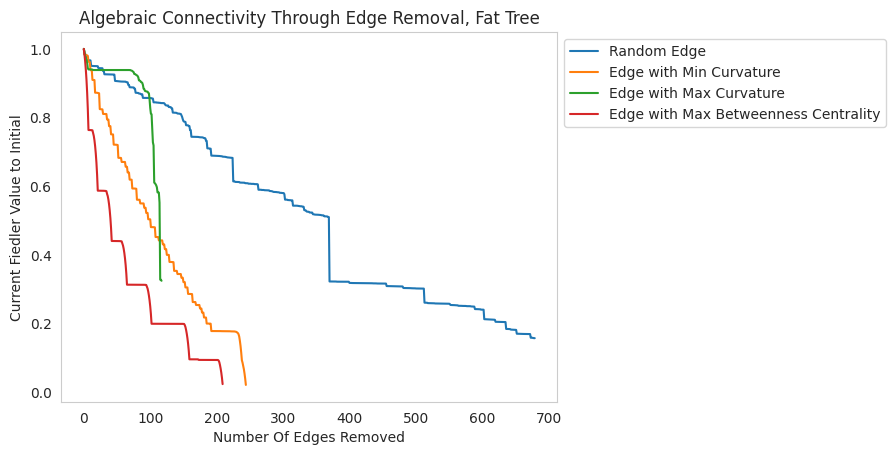

In [ ]:

def removalUntilDisconnectedPlot(topologies):
  rand, ricciMin, ricciMax, betweenness = [], [], [], []
  for i in range(len(topologies)):
    G = fileToGraph(os.path.join(base_filePath, topologies[i][1]))
    num_edges  = G.number_of_edges()
    H = G.copy()
    num_removed = 0
    edges = set(H.edges())
    while True:
      u, v = edges.pop()
      H.remove_edge(u, v)
      if not nx.is_connected(H):
        H.add_edge(u, v)
        break
      num_removed += 1
    rand.append((num_removed / num_edges) * 100)
    H = G.copy()
    H = addCurvatures(H)
    heap, num_removed = [], 0
    for a,b in H.edges:
      heapq.heappush(heap, (H[a][b]['ricciCurvature'], (a,b)))
    while True:
      if heap:
        a,b = heapq.heappop(heap)[1]
        H.remove_edge(a,b)
      if not nx.is_connected(H):
        H.add_edge(a,b)
        break
      num_removed += 1
    ricciMin.append((num_removed / num_edges) * 100)
    H = G.copy()
    H = addCurvatures(H)
    heap, num_removed = [], 0
    for a,b in H.edges:
      heapq.heappush(heap, (-H[a][b]['ricciCurvature'], (a,b)))
    while True:
      if heap:
        a,b = heapq.heappop(heap)[1]
        H.remove_edge(a,b)
      if not nx.is_connected(H):
        H.add_edge(a,b)
        break
      num_removed += 1
    ricciMax.append((num_removed / num_edges) * 100)
    H = G.copy()
    heap, num_removed = [], 0
    betweennessCentrality = nx.edge_betweenness_centrality(H)
    for a,b in H.edges:
      heapq.heappush(heap, (-betweennessCentrality[(a,b)], (a,b)))
    while True:
      if heap:
        a,b = heapq.heappop(heap)[1]
        H.remove_edge(a,b)
      if not nx.is_connected(H):
        H.add_edge(a,b)
        break
      num_removed += 1
    betweenness.append((num_removed / num_edges) * 100)
    print(topologies[i][0] + ' done')
  x_axis = np.arange(len(topologies))
  plt.xticks(x_axis, [t[0] for t in topologies])
  plt.tick_params(axis='x', labelsize=6)
  plt.bar(x_axis - 0.2, rand, 0.2, label = 'Random')
  plt.bar(x_axis, ricciMin, 0.2, label = 'Min Ricci Curvature')
  plt.bar(x_axis + 0.2, ricciMax, 0.2, label = 'Max Ricci Curvature')
  plt.bar(x_axis + 0.4, betweenness, 0.2, label = 'Max Betweenness Centrality')
  plt.xlabel('Topologies')
  plt.ylabel('Percentage of Edges Removed')
  plt.title("Percentage of Edges Removed Until Disconnected")
  plt.grid(visible = False)
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.show()


def calculate_FiedlerValue(G):
  m = G.laplacian()
  return np.linalg.eigvalsh(m)[1]

def removalFiedlerLinePlot(topology):
  rand, ricciMin, ricciMax, betweenness = [], [], [], []
  G_nx = fileToGraph(os.path.join(base_filePath, topology[1]))
  G_ig = ig.Graph.from_networkx(G_nx)
  fiedler_initial = calculate_FiedlerValue(G_ig)
  H = G_ig.copy()
  edges = set(H.get_edgelist())
  while H.is_connected():
    rand.append(calculate_FiedlerValue(H) / fiedler_initial)
    u, v = edges.pop()
    H.delete_edges([(u, v)])
  H = ig.Graph.from_networkx(addCurvatures(G_nx))
  heap = []
  for e in H.es:
    heapq.heappush(heap, (e['ricciCurvature'], (e.source, e.target)))
  while H.is_connected():
    ricciMin.append(calculate_FiedlerValue(H) / fiedler_initial)
    _, (a,b) = heapq.heappop(heap)
    H.delete_edges([(a,b)])
  H = ig.Graph.from_networkx(addCurvatures(G_nx))
  heap = []
  for e in H.es:
    heapq.heappush(heap, (-e['ricciCurvature'], (e.source, e.target)))
  while H.is_connected():
    ricciMax.append(calculate_FiedlerValue(H) / fiedler_initial)
    _, (a,b) = heapq.heappop(heap)
    H.delete_edges([(a,b)])
  H = G_ig.copy()
  heap = []
  betweennessCentrality = H.edge_betweenness()
  for i, edge in enumerate(H.get_edgelist()):
    a, b = edge
    heapq.heappush(heap, (-betweennessCentrality[i], (a,b)))
  while H.is_connected():
    betweenness.append(calculate_FiedlerValue(H) / fiedler_initial)
    _, (a,b) = heapq.heappop(heap)
    H.delete_edges([(a,b)])

  plt.plot([i for i in range(len(rand))], rand, label = 'Random Edge')
  plt.plot([i for i in range(len(ricciMin))], ricciMin, label = 'Edge with Min Curvature')
  plt.plot([i for i in range(len(ricciMax))], ricciMax, label = 'Edge with Max Curvature')
  plt.plot([i for i in range(len(betweenness))], betweenness, label = 'Edge with Max Betweenness Centrality')
  plt.xlabel('Number Of Edges Removed')
  plt.ylabel('Current Fiedler Value to Initial')
  plt.grid(visible = False)
  plt.title('Algebraic Connectivity Through Edge Removal, Fat Tree')
  plt.legend(bbox_to_anchor = (1,1), loc = 'upper left')
  plt.show()


#removalUntilDisconnectedPlot([('Fat Tree', 'FT3.10.adj.txt')])
removalFiedlerLinePlot(['Fat Tree', 'FT3.14.adj.txt'])




# Comparisons of speed of graph disconnection under different types of edge removal